<a href="https://colab.research.google.com/github/devkumar24/Image-Classification-Cifar10/blob/master/Cifar10_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.initializers import glorot_uniform

In [4]:
def load_dataset(name_of_dataset):
    (X_train, Y_train) , (X_test, Y_test) = name_of_dataset.load_data()
    
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = load_dataset(cifar10)

In [5]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [6]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [7]:
print(Y_train.shape)
print(Y_test.shape)

(50000, 10)
(10000, 10)


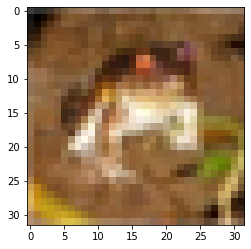

In [8]:
def display_image(image):
    image = image.reshape((32,32,3))
    plt.imshow(image)
    plt.show()

display_image(X_train[0])

In [9]:
def normalize(X_train, X_test):
    X_train = X_train.astype('float32')/255.
    X_test = X_test.astype('float32')/255.
    
    return X_train, X_test

In [10]:
X_train, X_test = normalize(X_train,X_test)

In [11]:
dict = {
    0: 'Airplane',
    1: 'Car',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck',
}

In [14]:

def ResNet50(input_shape = (32, 32, 3), classes = 10):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [12]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X


def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [15]:
model = ResNet50(input_shape=(32,32,3),classes=10)
model.summary()

In [18]:
model.compile( optimizer='adam', loss = "categorical_crossentropy", metrics=['accuracy'] )

In [ ]:
hist = model.fit(X_train, Y_train, batch_size = 128, epochs = 20, validation_split= 0.2, shuffle= True, validation_batch_size=256 )

Epoch 1/20
 88/313 [=======>......................] - ETA: 57:02 - loss: 4.9219 - accuracy: 0.1441

In [34]:
history = hist.history

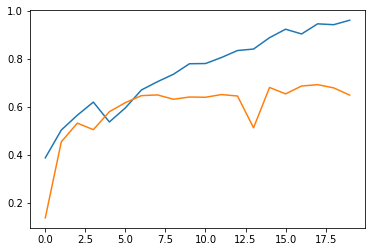

In [35]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])

In [31]:
acc = model.evaluate(X_test,Y_test)

313/313 [==============================] - 7s 21ms/step - loss: 2.8758 - accuracy: 0.6427


[2.875809907913208, 0.6427000164985657]

In [36]:
print("Accuracy Of Model->", acc[1]*100)
print("Loss  Of Model->", acc[0])

NameError: ignored

In [32]:
model.save("Model-Resnet.h5")